In [4]:
import os
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset
import imageio.v3 as iio
import numpy as np
import matplotlib.pyplot as plt
import time
from pthflops import count_ops
from tqdm import tqdm
import math

print(torch.__version__)

torch.manual_seed(42)

2.0.1


In [35]:
#Load video file
vRead = iio.imread('data/c_elegans.mp4')
video = np.array(vRead)
testFrame = video[1]

In [5]:
print("Cuda available: ", torch.cuda.is_available())
if(torch.cuda.is_available()):
    torch.cuda.set_device("cuda:1")

    print("Is cuDNN version:", torch.backends.cudnn.version())

    print("cuDNN enabled:a", torch.backends.cudnn.enabled)

    print("Device count: ", torch.cuda.device_count())

    print("Current device: ", torch.cuda.current_device())

    print("Device name: ", torch.cuda.get_device_name(torch.cuda.current_device()))
#Setup device agnostic code (i.e use GPU if possible)
device = "cuda" if torch.cuda.is_available() else "cpu"
gpuNum = 1
print(device)

Cuda available:  True
Is cuDNN version: 8700
cuDNN enabled:a True
Device count:  4
Current device:  1
Device name:  NVIDIA TITAN Xp
cuda


In [37]:
#Video Metadata
import imageio.v3 as iio
props = iio.improps("data/c_elegans.mp4")
print("Shape (frames, w, h, RGB): \n" + str(props.shape))
numFrames = props.shape[0]
print(props.dtype)

Shape (frames, w, h, RGB): 
(2484, 322, 344, 3)
uint8


In [7]:
if(os.path.isfile('testFrame.png') == False):
    frame1 = iio.imwrite('testFrame.png', testFrame,format='PNG')
else:
    print("test frame is already stored locally")

test frame is already stored locally


(512, 512, 3)


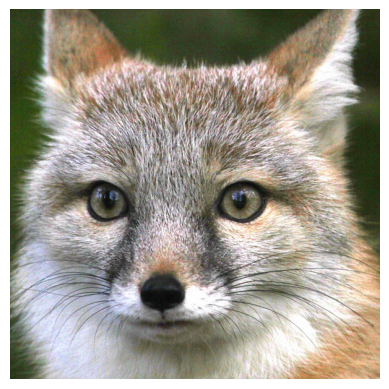

In [6]:
#process fox picture ONLY
image_url = 'https://live.staticflickr.com/7492/15677707699_d9d67acf9d_b.jpg'
imgFox = iio.imread(image_url)[..., :3] / 255
c = [imgFox.shape[0]//2, imgFox.shape[1]//2]
r = 256
imgFox = imgFox[c[0]-r:c[0]+r, c[1]-r:c[1]+r]

plt.imshow(imgFox)
plt.axis('off')
print(imgFox.shape)
img = imgFox
coords = np.linspace(0, 1, 512, endpoint=False)
x_test = np.stack(np.meshgrid(coords, coords), -1)
test_data = [x_test, img]


tensor([[[0.0157, 0.0157, 0.0157],
         [0.0667, 0.0667, 0.0667],
         [0.0902, 0.0902, 0.0902],
         ...,
         [0.0039, 0.0000, 0.0000],
         [0.0039, 0.0000, 0.0000],
         [0.0039, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392],
         [0.0588, 0.0588, 0.0588],
         ...,
         [0.0039, 0.0000, 0.0000],
         [0.0039, 0.0000, 0.0000],
         [0.0039, 0.0000, 0.0000]],

        [[0.0706, 0.0706, 0.0706],
         [0.1020, 0.1020, 0.1020],
         [0.0863, 0.0863, 0.0863],
         ...,
         [0.0039, 0.0000, 0.0000],
         [0.0039, 0.0000, 0.0000],
         [0.0039, 0.0000, 0.0000]],

        ...,

        [[0.0157, 0.0157, 0.0157],
         [0.0392, 0.0392, 0.0392],
         [0.0196, 0.0196, 0.0196],
         ...,
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000],
         [0.0667, 0.0667, 0.0667],
         [0.

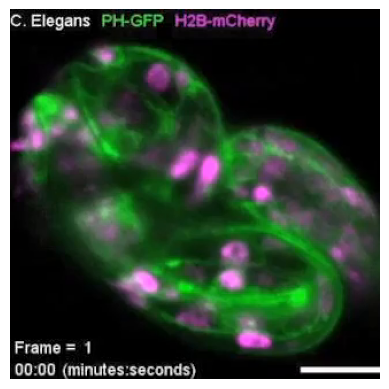

In [38]:
#FOR LOCAL IMAGE ONLY
#Square the image
l = min(2*(props.shape[1]//2), 2*(props.shape[2]//2))
#Encode Tensor
inputFrame = iio.imread('testFrame.png')
frame = torch.as_tensor(testFrame)[:l, :l]

preImg = torch.as_tensor(frame).to(device)
img = torch.mul(preImg, 1/255.0).type(torch.float64)
print(img)
plt.imshow(img.cpu())
plt.axis('off')
print('img is now on', img.device)
print(img.shape)

#generate coordinates in unit square
coords = np.linspace(0, 1, l, endpoint=False)
x_test = np.stack(np.meshgrid(coords, coords), -1)
test_data = [x_test, img]
print('shape of test data: ', x_test.shape)

In [39]:
def input_mapping(x, B):
    #print("shape of x:", x.shape)
    #print("shape of B:", B.shape)
    if B is None:
        return x
    else:
        B_T = np.array(B).T
        #print("B_T", B_T.shape)
        x_proj = torch.as_tensor(np.dot(2.0*(np.pi)* x, B_T))
        #print("x_proj:", x_proj, x_proj.shape)
        return np.concatenate([np.sin(x_proj), np.cos(x_proj)], axis=-1)   
#basic_mapping(np.array([1,1]), np.eye(2))

In [10]:
gen = torch.Generator()
gen.manual_seed(42)
gauss_mat = torch.normal(0.0, 1, size=(256, 2), generator=gen)

In [40]:
seed = 42
mapping_size = 256
mappings = {}
mappings['raw'] = None
mappings['identity'] = np.eye(2)
# ex: [1, 10, 100]
mappings['gaussian_fourier'] = lambda scale: scale * gauss_mat
print(mappings['gaussian_fourier'](25).shape)

torch.Size([256, 2])


In [6]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms

class MLP(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(input_shape, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units), 
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units), 
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units), 
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.Sigmoid(),
            nn.Linear(hidden_units, output_shape),
        )
    def forward(self, X):
        return self.layer_stack(X.to(device).type(torch.float32))


In [7]:
#INPUT SIZE IS 4 FOR BASIC AN NO-ENCODING
#I HAVE TO FIX THE GAUSSIAN ONES BECAUSE THEY ARE WACK WITH Huge matrix sizes
model_0 = MLP(input_shape=512, 
              hidden_units=256,
              output_shape=3).to(device)


In [8]:

lr1 = 0.0001
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=lr1)

In [57]:
### Save Model State Dictionary
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "pos_encoding_gauss_25_c_elegans_frame_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
MODEL_SAVE_PATH

#3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)
print(MODEL_SAVE_PATH)

Saving model to: models/pos_encoding_gauss_25_c_elegans_frame_1.pth
models/pos_encoding_gauss_25_c_elegans_frame_1.pth


In [9]:
##LOAD MODEL
# To load in a saved state_dict we have to instantiate a new instance of our model class
#loaded_model_0 = MLP() # new instance!

#Load the saved state_dict of model_0 (this wil updated the new instance with the updated parameters.)
model_0.load_state_dict(torch.load(f='models/pos_encoding_gauss_25_c_elegans_frame_0.pth'))

<All keys matched successfully>

In [75]:
#dataLoader
from torch.utils.data import DataLoader

class SingleImageDataset(Dataset):
    def __init__(self, data, mapping, transform=None, target_transform=None):
        self.train_data = data[0]
        self.img = data[1]
        self.B = mapping
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return img.shape[0] * img.shape[1]
    def __getitem__(self, idx):
        row = idx // int(img.shape[1])
        col = idx % int(img.shape[1])
        coords = torch.as_tensor(self.train_data[row][col]).type(torch.float64)
        pixel = torch.as_tensor(self.img[row][col]).type(torch.float64)
        return torch.as_tensor(input_mapping(coords, self.B)).type(torch.float64).cpu(), pixel.cpu()
training_data = SingleImageDataset(test_data, mappings['gaussian_fourier'](25))

In [76]:
import math
def PSNR(MSELoss, max):
    return (20*math.log10(max)) - (10*math.log10(MSELoss))

In [77]:
#No mapping/encoding
from tqdm import tqdm

train_loader = DataLoader(training_data, batch_size=512, shuffle=True, pin_memory=True)
batchCount = 0
psnr_table = []
for epoch in tqdm(range(0,30)):
    #Training
    model_0.train()
    for batch in iter(train_loader):
        #print(batch[0].shape)
        batchCount += 1
        encodings = torch.as_tensor(batch[0]).to(device)
        y_train = torch.as_tensor(batch[1]).to(device)
        y_train = torch.squeeze(y_train)
        X = torch.as_tensor(encodings).type(torch.float64).to(device)
        y_train = torch.as_tensor(y_train).type(torch.float64).to(device)
        # Forward Pass
        y_pred = model_0(X).to(device).type(torch.float64)
        loss = loss_fn(y_pred, y_train)
        psnr = PSNR(loss, 1.0)
        psnr_table.append(psnr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 1 == 0:
        print(f"Epoch: {epoch} | LR: {lr1} | Train loss: {loss} | PSNR: {psnr}")
    if epoch == 10:
        lr1 = lr1/10
    if epoch == 20:
        lr1 = lr1/2
print('Training Finished')


  3%|▎         | 1/30 [00:14<07:12, 14.93s/it]

Epoch: 0 | LR: 0.0001 | Train loss: 0.0008613996152820686 | PSNR: 30.64795326537793


  7%|▋         | 2/30 [00:29<06:50, 14.66s/it]

Epoch: 1 | LR: 0.0001 | Train loss: 0.0007981739481080624 | PSNR: 30.979024514173847


 10%|█         | 3/30 [00:45<06:51, 15.25s/it]

Epoch: 2 | LR: 0.0001 | Train loss: 0.000910210453219884 | PSNR: 30.408581811899364


 13%|█▎        | 4/30 [01:01<06:44, 15.55s/it]

Epoch: 3 | LR: 0.0001 | Train loss: 0.0008561402836226283 | PSNR: 30.674550677860182


 17%|█▋        | 5/30 [01:18<06:39, 15.97s/it]

Epoch: 4 | LR: 0.0001 | Train loss: 0.0005499288616074147 | PSNR: 32.596934868867436


 20%|██        | 6/30 [01:35<06:38, 16.62s/it]

Epoch: 5 | LR: 0.0001 | Train loss: 0.0005798319382886345 | PSNR: 32.36697866524143


 23%|██▎       | 7/30 [01:50<06:06, 15.92s/it]

Epoch: 6 | LR: 0.0001 | Train loss: 0.0005702335489905939 | PSNR: 32.43947235092375


 27%|██▋       | 8/30 [02:06<05:53, 16.09s/it]

Epoch: 7 | LR: 0.0001 | Train loss: 0.00047734647957209733 | PSNR: 33.211662760069025


 30%|███       | 9/30 [02:25<05:51, 16.75s/it]

Epoch: 8 | LR: 0.0001 | Train loss: 0.000534782922954549 | PSNR: 32.71822469370074


 33%|███▎      | 10/30 [02:40<05:27, 16.37s/it]

Epoch: 9 | LR: 0.0001 | Train loss: 0.0005497457490028023 | PSNR: 32.598381202059414


 37%|███▋      | 11/30 [02:55<05:04, 16.01s/it]

Epoch: 10 | LR: 0.0001 | Train loss: 0.00036380250161750945 | PSNR: 34.391343189202956


 40%|████      | 12/30 [03:12<04:53, 16.33s/it]

Epoch: 11 | LR: 1e-05 | Train loss: 0.0004932649986864237 | PSNR: 33.069197003024


 43%|████▎     | 13/30 [03:30<04:43, 16.68s/it]

Epoch: 12 | LR: 1e-05 | Train loss: 0.00040129920053918333 | PSNR: 33.96531705458703


 47%|████▋     | 14/30 [03:44<04:15, 15.99s/it]

Epoch: 13 | LR: 1e-05 | Train loss: 0.00038716511031088323 | PSNR: 34.12103786389918


 50%|█████     | 15/30 [03:59<03:55, 15.71s/it]

Epoch: 14 | LR: 1e-05 | Train loss: 0.00026623755780136207 | PSNR: 35.747306791568604


 53%|█████▎    | 16/30 [04:15<03:41, 15.85s/it]

Epoch: 15 | LR: 1e-05 | Train loss: 0.0003634355338896864 | PSNR: 34.395726130275214


 57%|█████▋    | 17/30 [04:31<03:22, 15.60s/it]

Epoch: 16 | LR: 1e-05 | Train loss: 0.00032948911843763814 | PSNR: 34.82158923651226


 60%|██████    | 18/30 [04:50<03:21, 16.75s/it]

Epoch: 17 | LR: 1e-05 | Train loss: 0.00028554005446907935 | PSNR: 35.443329619724


 63%|██████▎   | 19/30 [05:07<03:06, 16.96s/it]

Epoch: 18 | LR: 1e-05 | Train loss: 0.0002293359066029314 | PSNR: 36.39527943444106


 67%|██████▋   | 20/30 [05:26<02:53, 17.39s/it]

Epoch: 19 | LR: 1e-05 | Train loss: 0.0002538520066678207 | PSNR: 35.95419399203173


 70%|███████   | 21/30 [05:41<02:30, 16.70s/it]

Epoch: 20 | LR: 1e-05 | Train loss: 0.0002936417400430815 | PSNR: 35.32182211079031


 73%|███████▎  | 22/30 [05:57<02:11, 16.46s/it]

Epoch: 21 | LR: 5e-06 | Train loss: 0.00032993644813800323 | PSNR: 34.815697052159486


 77%|███████▋  | 23/30 [06:12<01:52, 16.01s/it]

Epoch: 22 | LR: 5e-06 | Train loss: 0.00033584761756421267 | PSNR: 34.738577281525025


 80%|████████  | 24/30 [06:28<01:36, 16.14s/it]

Epoch: 23 | LR: 5e-06 | Train loss: 0.00024191653643269498 | PSNR: 36.163344440150986


 83%|████████▎ | 25/30 [06:44<01:19, 15.97s/it]

Epoch: 24 | LR: 5e-06 | Train loss: 0.0004037216094802392 | PSNR: 33.93918004053015


 87%|████████▋ | 26/30 [06:58<01:02, 15.57s/it]

Epoch: 25 | LR: 5e-06 | Train loss: 0.00024833329870594653 | PSNR: 36.04965042529023


 90%|█████████ | 27/30 [07:12<00:45, 15.13s/it]

Epoch: 26 | LR: 5e-06 | Train loss: 0.00035640894998513977 | PSNR: 34.48051398685793


 93%|█████████▎| 28/30 [07:29<00:31, 15.53s/it]

Epoch: 27 | LR: 5e-06 | Train loss: 0.000289472128333992 | PSNR: 35.38393245730908


 97%|█████████▋| 29/30 [07:46<00:15, 15.88s/it]

Epoch: 28 | LR: 5e-06 | Train loss: 0.00021098474095460778 | PSNR: 36.757489530380724


100%|██████████| 30/30 [08:01<00:00, 16.05s/it]

Epoch: 29 | LR: 5e-06 | Train loss: 0.00025590230511075596 | PSNR: 35.91925802067591
Training Finished


In [10]:
#Plot PSNR
plt.plot(range(0,batchCount), psnr_table)
plt.title('Train error')
plt.ylabel('PSNR')
#NOT EPOCHS - THESE ARE BATCHES!!!
plt.xlabel('Batch Iter')
plt.legend()

plt.show()

NameError: name 'batchCount' is not defined

In [11]:
print(psnr_table)

NameError: name 'psnr_table' is not defined

In [ ]:
def basic_encoding_reconstruction():
    model_0.eval()
    x_test_T = torch.as_tensor(x_test)
    reconstruction_input_matrix = torch.zeros(x_test_T.shape[0], x_test_T.shape[1], 4)
    #encode coordinates into debug matrix
    for i in range(0, x_test_T.shape[0]):
        for j in range(0, x_test_T.shape[1]):
            reconstruction_input_matrix[i][j] = torch.as_tensor(input_mapping(x_test_T[i][j], np.eye(2)))

    with torch.inference_mode():
        reconstruction = model_0(reconstruction_input_matrix).cpu()
        plt.imshow(reconstruction)
        plt.axis(False)
        plt.title("Basic Encoding")


In [32]:
#Gaussian-Fourier Encoding tester
#Part 1: Generate debug matrix
model_0.eval()
fileName = 'gauss_25_reconstruction_matrix.pt'
if(os.path.isfile(fileName) == False): 
    print('file', fileName, 'does not exist. generating matrix as tensor...') 
    x_test_T = torch.as_tensor(x_test)
    reconstruction_input_matrix = torch.zeros(x_test_T.shape[0], x_test_T.shape[1], 512)
    #encode coordinates into debug matrix
    for i in range(0, x_test_T.shape[0]):
        for j in range(0, x_test_T.shape[1]):
            SCALE = 25
            reconstruction_input_matrix[i][j] = torch.as_tensor(input_mapping(x_test_T[i][j], mappings["gaussian_fourier"](SCALE))).type(torch.float64)
    #SAVE MATRIX
    torch.save(reconstruction_input_matrix, fileName)
else:
    reconstruction_input_matrix = torch.load(fileName)
    print(fileName, 'already exists-- loading tensor...')
    print(reconstruction_input_matrix.shape)

gauss_25_reconstruction_matrix.pt already exists-- loading tensor...
torch.Size([322, 322, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


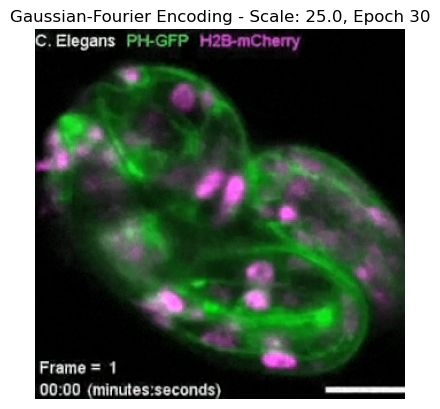

In [79]:
# Run Forward model with test matrix to output full reconstruction (2D)
with torch.inference_mode():
    reconstruction = model_0(reconstruction_input_matrix).cpu()
    plt.imshow(reconstruction)
    plt.axis(False)
    plt.title("Gaussian-Fourier Encoding - Scale: 25.0, Epoch 30")


In [43]:
# Signal Processing Feature Extraction/data
model_0.eval()
with torch.inference_mode():
    print(len(model_0.layer_stack))
    for i in range(0,len(model_0.layer_stack)):
        if isinstance(model_0.layer_stack[i], torch.nn.Linear):
           print('layer:', i)
           print(torch.as_tensor(model_0.layer_stack[i].weight))
    


11
layer: 0
Parameter containing:
tensor([[ 0.0233,  0.0385, -0.0112,  ..., -0.0011, -0.0023, -0.0531],
        [ 0.0194, -0.0311, -0.0142,  ..., -0.0240, -0.0322, -0.0056],
        [ 0.0065,  0.0001,  0.0398,  ...,  0.0078, -0.0259, -0.0518],
        ...,
        [ 0.0244,  0.0110, -0.0043,  ...,  0.0229, -0.0541, -0.0294],
        [-0.0268,  0.0240, -0.0038,  ...,  0.0551,  0.0010, -0.0859],
        [-0.0349,  0.0077, -0.0239,  ...,  0.0032, -0.0163, -0.0126]],
       device='cuda:1', requires_grad=True)
layer: 2
Parameter containing:
tensor([[ 5.2750e-02, -7.9812e-02,  1.6416e-02,  ...,  3.9971e-02,
         -1.1432e-02, -4.3404e-02],
        [-7.3200e-03,  3.6620e-02,  1.4075e-02,  ...,  2.6224e-02,
          4.1877e-02, -2.9903e-02],
        [-9.8484e-04, -3.4548e-02,  4.2624e-04,  ..., -1.3520e-02,
          2.8736e-02, -1.2927e-02],
        ...,
        [-5.8660e-02, -2.0767e-02, -1.4433e-02,  ..., -5.2167e-02,
          2.5436e-02,  1.0465e-05],
        [ 4.2689e-02, -1.3002e-0

In [ ]:
    print(reconstruction_input_matrix.shape)
    print(first_layer.shape)
    print(second_layer.shape)
    first_feature_layer = torch.matmul(first_layer, reconstruction_input_matrix.cpu())
    first_feature_layer = torch.sigmoid(first_feature_layer)
    second_feature_layer = torch.matmul(second_layer, first_feature_layer)
    plt.imshow(second_feature_layer.numpy())


In [42]:
print(model_0.state_dict()['layer_stack.0.weight'])

tensor([[ 0.0233,  0.0385, -0.0112,  ..., -0.0011, -0.0023, -0.0531],
        [ 0.0194, -0.0311, -0.0142,  ..., -0.0240, -0.0322, -0.0056],
        [ 0.0065,  0.0001,  0.0398,  ...,  0.0078, -0.0259, -0.0518],
        ...,
        [ 0.0244,  0.0110, -0.0043,  ...,  0.0229, -0.0541, -0.0294],
        [-0.0268,  0.0240, -0.0038,  ...,  0.0551,  0.0010, -0.0859],
        [-0.0349,  0.0077, -0.0239,  ...,  0.0032, -0.0163, -0.0126]],
       device='cuda:1')


In [44]:
quit()

: 

In [9]:
# Check model size by summing parameters and state_dict
params_size = 0
for param in model_0.parameters():
    params_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model_0.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (params_size + buffer_size) / 1024**2
imageSize = 8 * img.shape[0] * img.shape[1] * img.shape[2]
imageSizeMB = imageSize / (10**6)
perDecrease = (imageSizeMB - size_all_mb) / imageSizeMB
perDecrease *= 100
print('original image size(no compression): {:.3f}MB'.format(imageSizeMB))
print('model size: {:.3f}MB'.format(size_all_mb))
print('Percent decrease in memory size: {:.3f}%'.format(perDecrease))

original image size(no compression): 6.291MB
model size: 1.508MB
Percent decrease in memory size: 76.034%
